#  Revealing mesocale structures of time-varying networks through non-negative tensor factorization

In this notebook we show how the method presented in [[1]](#1) can be applied to data about face-to-face proximity relations collected in a school.

The data were collected by the [SocioPatterns collaboration](http://www.sociopatterns.org) using wearable proximity sensors that sense the face-to-face proximity relations of individuals wearing them. 

A few libraries are required in order to run this notebook. The Python Pandas library is used for data loading and manipulation, the `sktensor` library is used to represent the 3-way tensors and the `ncp` script contains the algorithms for the non-negative tensor factorization.

In [1]:
%pylab inline

import pandas as pd
import sktensor

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [3]:
import ncp

In the following we load the expected structures (classes) that are used as a validation for the methodology.

The population of the school consisted of 231 children, organized in 10 classes, and 10 teachers.

In [4]:
classes = pd.read_csv("data/classes.csv", index_col=0, squeeze=True)
print classes.size
print classes.unique()

241
['cm1a' 'ce2b' 'cm2b' 'cm1b' 'ce1a' 'cm2a' 'teachers' 'cpb' 'ce1b' 'cpa'
 'ce2a']


The data collected through the SocioPatterns platorm is represented as triples $<t, i, j>$ where $i,j$ is a pair of nodes that were in proximity during the interval between time $t$ and $t+20$.

It represents 2 days of activity in a school. We selected only the hours when the kids were at school, for a total of 18 hours (two intervals of 9 hours per day concatenated as a single interval, thus removing the night).

In [5]:
data = pd.read_csv("data/school.csv.gz", compression="gzip")
data.head()

,t,i,j
0,0,0,1
1,0,0,2
2,0,0,222
3,0,1,222
4,0,2,228


In [6]:
print data.t.max() / 3600., "hours"

18.0277777778 hours


From the timeline that shows the sum of number of contacts for each 20 seconds interval, we see that there is a small interval with no activity between the two 9 hours interval, in order to show where one day ends and starts the other.

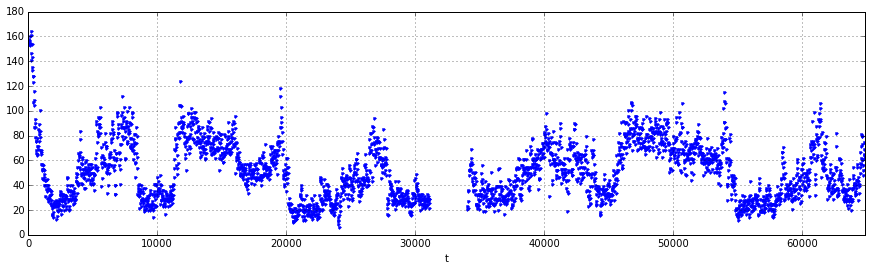

In [7]:
data.groupby(data.t).t.count().plot(linestyle='None', marker='.', figsize=(15,4));

In [8]:
NR_NODES = classes.index.unique().shape[0]
NR_INTERVALS = 150

For the purpose of this experiment, we divide the timeline in 150 different intervals.

In [9]:
data_binned = data.groupby((data.t / ((data.t.max()+1) / float(NR_INTERVALS))).astype(int))

In [10]:
def create_adj(g):
    return g.groupby(['i','j']).size()

school_adj_series = data_binned.apply(create_adj)
school_adj_series.head()

t  i  j  
0  0  1      15
      2      15
      222    15
   1  219     4
      222    15
dtype: int64

We transform the $<t, i, j>$ triples in a 3-way binary tensor.

In [11]:
triples = array([(i, j, t) for t, i, j in school_adj_series.keys()] + 
                [(j, i, t) for t, i, j in school_adj_series.keys()])

X = sktensor.sptensor(tuple(triples.T), ones(len(triples)),
                      shape=(NR_NODES, NR_NODES, NR_INTERVALS))

The tensor is factorized using the alternating non-negative least squares algorithm with the block principal pivoting method, proposed in [[2]](#2).

In [12]:
np.random.seed(4)

X_approx_ks = ncp.nonnegative_tensor_factorization(X, 14, method='anls_bpp')

The result of the factorization is a set of loading matrices $\mathbf{A, B, C}$.

In [13]:
A = X_approx_ks.U[0]
B = X_approx_ks.U[1]
C = X_approx_ks.U[2]

We then group the rows of $\mathbf{A}$ by class and sum the values, in order to check how much of each class is represented in each one of the factors.

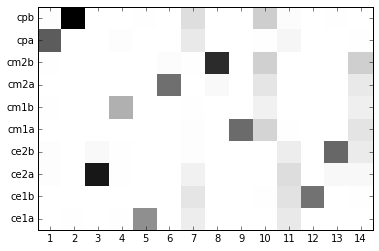

In [14]:
dfa = pd.DataFrame(A).groupby(classes).sum()
dfa = dfa[dfa.index!='teachers']

plt.pcolormesh(dfa.values, cmap=plt.cm.Greys)
plt.xlim(0, dfa.shape[1])
plt.yticks(arange(10)+0.5, dfa.index)
plt.xticks(arange(14)+0.5, arange(1,15));

The activity timeline of each factor is represented in $\mathbf{C}$.

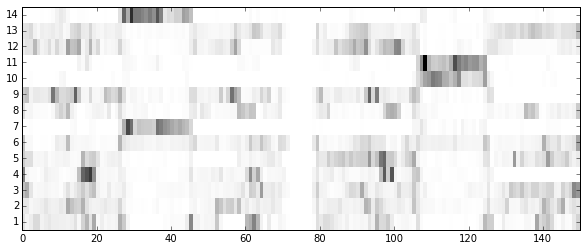

In [15]:
figure(figsize=(10,4))
plt.pcolormesh(C.T, cmap=plt.cm.Greys)
plt.xlim(0,C.shape[0])
plt.yticks(arange(14)+0.5, arange(1,15));

We can also reorder the factors to show better the results of the factorization.

In [16]:
factor_order = [1, 0, 7, 5, 3, 8, 12, 2, 11, 4, 6, 13, 9, 10]

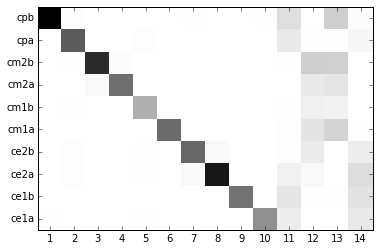

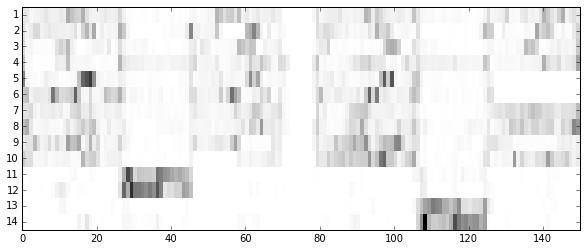

In [17]:
dfa = pd.DataFrame(A).groupby(classes).sum()
dfa = dfa[dfa.index!='teachers']

figure()
plt.pcolormesh(dfa.values[:, factor_order], cmap=plt.cm.Greys)
plt.xlim(0, dfa.shape[1])
plt.yticks(arange(10)+0.5, dfa.index)
plt.xticks(arange(14)+0.5, arange(1,15));

figure(figsize=(10,4))
plt.pcolormesh(C[:, factor_order[::-1]].T, cmap=plt.cm.Greys)
plt.xlim(0, C.shape[0])
plt.yticks(arange(14)+0.5, arange(14,0,-1));

References:

<a name="1"></a>[1] L. Gauvin, A. Panisson, C. Cattuto. [Detecting the Community Structure and Activity Patterns of Temporal Networks: A Non-Negative Tensor Factorization Approach](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0086028#pone-0086028-g001) PLOS ONE 9.1 (2014): e86028.

<a name="2"></a> [2] Kim J, Park H (2012) Fast nonnegative tensor factorization with an active-set-like method. In: Berry MW, Gallivan KA, Gallopoulos E, Grama A, Philippe B, et al., editors, High-Performance Scientific Computing, Springer London. 311–326.